In [1]:
import underworld3 as uw
import numpy as np
import matplotlib.pyplot as plt
import sympy

In [2]:
length = 2000.0  # meters
width = 1000.0  # meters
K = 3.0e-3  # m/yr
Ss = 2.3e-4  # m^-1
hmax = 100.0  # meters

resolution = 64

# Constants
X = 2000.0  # meters
Y = 1000.0  # meters
K = 3.0e-3  # m/yr
Ss = 2.3e-4  # m^-1
hmax = 100.0  # meters

# Example usage
x = 1000.0  # meters
y = 500.0  # meters
t = 0  # years
qdeg = 3
Vdeg = 2
Hdeg = 1

In [3]:
def compute_h(x, y, t, length, width, K, Ss, hmax):
    pi = np.pi
    exponent = -((pi**2 * K * t) / Ss)
    term1 = np.exp((exponent) * ((1 / (length**2)) + (1 / (width**2))))
    term2 = np.sin((pi * x) / length) * np.sin((pi * y) / width)
    h = hmax * term1 * term2
    return h

computed_h = compute_h(x, y, t, length, width, K, Ss, hmax)
print(f"Computed h({x}, {y}, {t}): {computed_h} meters")

Computed h(1000.0, 500.0, 0): 100.0 meters


In [4]:
def compute_vel(x, y, t, length, width, K, Ss, hmax):
    pi = np.pi
    exponent = -(pi**2 * K * t) / Ss
    
    # Compute the amplitude factors
    amp1 = (K * hmax * pi) / length
    amp2 = (K * hmax * pi) / width

    # Velocity components based on the provided equations
    u = amp1 * np.exp(exponent * (1 / length**2 + 1 / width**2)) * np.cos(pi * x / length) * np.sin(pi * y / width)
    v = amp2 * np.exp(exponent * (1 / length**2 + 1 / width**2)) * np.sin(pi * x / length) * np.cos(pi * y / width)

    return u, v

In [5]:
xmin, xmax = 0, length
ymin, ymax = 0, width

In [6]:
meshbox = uw.meshing.UnstructuredSimplexBox(
                                                minCoords= (xmin, ymin),
                                                maxCoords= (xmax, ymax),
                                                cellSize= length / resolution,
                                                regular=False,
                                                qdegree = qdeg
                                        )

In [7]:
#Create mesh variables

v_soln  = uw.discretisation.MeshVariable("U", meshbox, meshbox.dim, degree = Vdeg)
h_soln  = uw.discretisation.MeshVariable("P", meshbox, 1, degree = Hdeg)

v  = uw.discretisation.MeshVariable("V", meshbox, meshbox.dim, degree = Vdeg)

with meshbox.access(v):
 v.data[:] = 0.0

In [8]:
with meshbox.access(h_soln, v_soln):
    for (i, (x, y)) in enumerate(h_soln.coords):
        #print(x, y)
        h_soln.data[i] = compute_h(x = x, y = y, t = t,length = length, width = width, K = K, Ss = Ss, hmax = hmax)
        
    for (i, (x, y)) in enumerate(v_soln.coords):
        v_soln.data[i, :] = compute_vel(x = x, y = y, t =t, length = length, width = width, K = K, Ss = Ss, hmax = hmax)

    print(h_soln.data.min(), h_soln.data.max())
    print(v_soln.data[:, 0].min(), v_soln.data[:, 0].max())
    print(v_soln.data[:, 1].min(), v_soln.data[:, 1].max())


0.0 99.91839052469368
-0.00047123889803846896 0.00047123889803846896
-0.0009424777960769379 0.0009424777960769379


In [9]:
xv = meshbox.N.x 
yv = meshbox.N.y

In [10]:
# u_num and v_num are the numerical solutions

u_num  = uw.discretisation.MeshVariable("Un", meshbox, 1, degree=Vdeg)
v_num  = uw.discretisation.MeshVariable("Vn", meshbox, 1, degree=Vdeg)

In [11]:
h_num = uw.discretisation.MeshVariable("H", meshbox, 1, degree= Hdeg)
vel_num  = uw.discretisation.MeshVariable("V2", meshbox, meshbox.dim, degree = Vdeg)

In [12]:
with meshbox.access(h_num):
    for (i, (x, y)) in enumerate(h_num.coords):
        #print(x, y)
        h_num.data[i] = compute_h(x = x, y = y, t = 0,length = length, width = width, K = K, Ss = Ss, hmax = hmax)

In [13]:
u_calc = uw.systems.Projection(meshbox, u_num)
u_calc.uw_function = K * sympy.diff(h_num.sym, xv)
u_calc.uw_function
 
v_calc = uw.systems.Projection(meshbox, v_num)
v_calc.uw_function = K * sympy.diff(h_num.sym, yv)
v_calc.uw_function

Matrix([[0.003*{H}_{,1}(N.x, N.y)]])

In [14]:
# Create the advDiff solver

adv_diff = uw.systems.AdvDiffusionSLCN(
    meshbox,
    u_Field=h_num,
    V_fn=v.sym,
    solver_name="adv_diff",
)

In [15]:
#add boundary conditions
adv_diff.add_dirichlet_bc(0., "Top")
adv_diff.add_dirichlet_bc(0., "Bottom")
adv_diff.add_dirichlet_bc(0., "Left")
adv_diff.add_dirichlet_bc(0., "Right")

In [16]:
# ### Set up properties of the adv_diff solver
# - Constitutive model (Diffusivity)
# - Boundary conditions
# - Internal velocity
# - Initial temperature distribution 

adv_diff.constitutive_model = uw.constitutive_models.DiffusionModel
adv_diff.constitutive_model.Parameters.diffusivity = 13.043478260869565

adv_diff.constitutive_model.Parameters.diffusivity.value

adv_diff.add_dirichlet_bc(0., "Top")
adv_diff.add_dirichlet_bc(0., "Bottom")
adv_diff.add_dirichlet_bc(0., "Left")
adv_diff.add_dirichlet_bc(0., "Right")


# print(adv_diff.estimate_dt())
# steps = int(dt // (12*adv_diff.estimate_dt()[1]))

In [17]:
steps = 5
dt= 2000
model_time = 0
for step in range(0, steps):
    adv_diff.solve(timestep= dt, zero_init_guess=False)
    model_time += dt
    print(f"Timestep: {step}/{steps}, model time {model_time}")

Timestep: 0/5, model time 2000
Timestep: 1/5, model time 4000
Timestep: 2/5, model time 6000
Timestep: 3/5, model time 8000
Timestep: 4/5, model time 10000


In [18]:
v_calc.solve()

In [19]:
u_calc.solve()

In [20]:
vis.vector_fn_to_pv_points?

Object `vis.vector_fn_to_pv_points` not found.


In [21]:
sympy.sqrt(v_soln.sym.dot(v_soln.sym))

sqrt({U}_{ 0 }(N.x, N.y)**2 + {U}_{ 1 }(N.x, N.y)**2)

In [22]:
if uw.mpi.size == 1:

        import pyvista as pv
        import underworld3.visualisation as vis

        pvmeshbox = vis.mesh_to_pv_mesh(meshbox)
        pvmeshbox.point_data["V"] = vis.vector_fn_to_pv_points(pvmeshbox, v_soln.sym)
        pvmeshbox.point_data["Vmag"] = vis.scalar_fn_to_pv_points(pvmeshbox, sympy.sqrt(v_soln.sym.dot(v_soln.sym)))
        pvmeshbox.point_data["T"] = vis.scalar_fn_to_pv_points(pvmeshbox, h_soln.sym)
        
        pl = pv.Plotter()

        pl.add_mesh(
            pvmeshbox,
            cmap="coolwarm",
            edge_color="Black",
            show_edges=True,
            scalars="T",
            use_transparency=False,
            show_scalar_bar=False,
            opacity=1,
        )



        # pl.add_points(T_points, color="White",
        #               scalars="dT", cmap="coolwarm",
        #               point_size=5.0, opacity=0.5)


        pl.add_arrows(pvmeshbox.points, pvmeshbox.point_data["V"], mag=1e-6, opacity=1, show_scalar_bar=False)

        # pl.add_points(pdata)

        pl.show(cpos="xy")

        # return vsol

#T_points.point_data["dT"].max()

adv_diff

adv_diff.F1

Widget(value='<iframe src="http://localhost:64291/index.html?ui=P_0x295202490_0&reconnect=auto" class="pyvista…

**Class**: <class 'underworld3.function.expressions.UWexpression'>

<IPython.core.display.Latex object>

$\quad$**Description:**  Poisson pointwise flux term: F_1(u)

<IPython.core.display.Latex object>

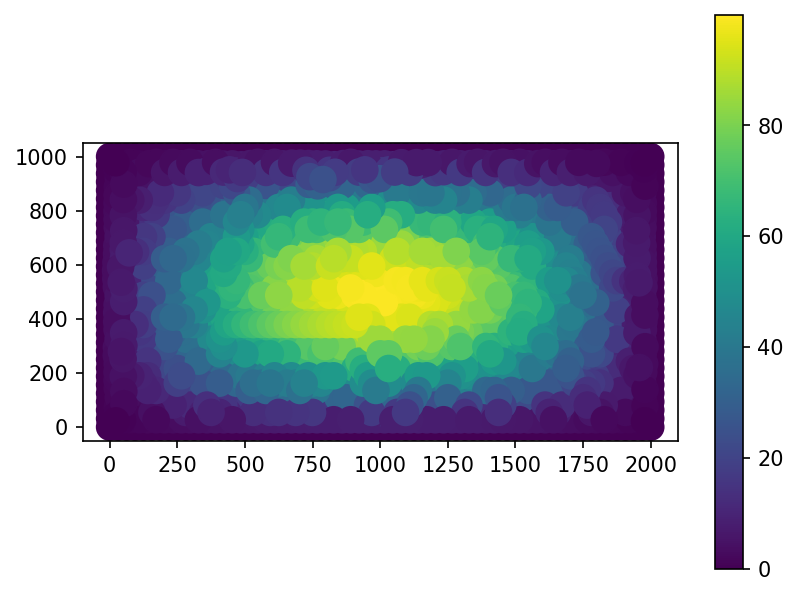

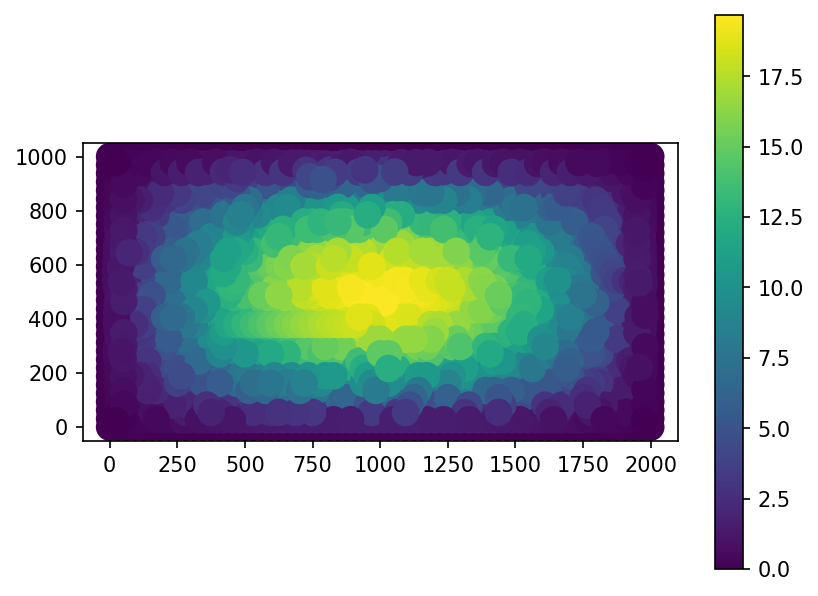

In [23]:
with meshbox.access(h_soln):
    fig, ax = plt.subplots(dpi = 150)
    out = ax.scatter(h_soln.coords[:, 0], h_soln.coords[:, 1], c = h_soln.data[:], s = 150)
    ax.set_aspect("equal")
    cbar = fig.colorbar(out)
    
with meshbox.access(h_num):
    fig, ax = plt.subplots(dpi = 150)
    out = ax.scatter(h_num.coords[:, 0], h_num.coords[:, 1], c = h_num.data[:], s = 150)
    ax.set_aspect("equal")
    cbar = fig.colorbar(out)

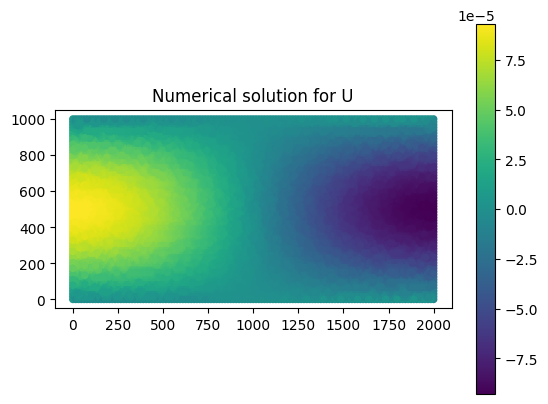

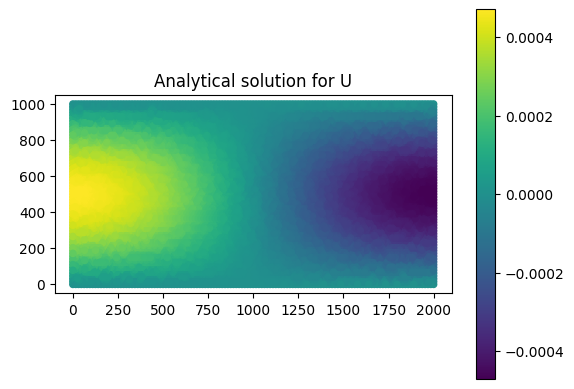

In [24]:
with meshbox.access(u_num):
    fig, ax = plt.subplots(dpi = 100)
    out = ax.scatter(u_num.coords[:, 0], u_num.coords[:, 1], c = u_num.data[:,0], s = 20)
    ax.set_aspect("equal")
    cbar = fig.colorbar(out)
    ax.set_title("Numerical solution for U")
 
    fig, ax = plt.subplots(dpi = 100)
    out2 = ax.scatter(v_soln.coords[:, 0], v_soln.coords[:, 1], c = v_soln.data[:, 0], s = 20)
    ax.set_aspect("equal")
    cbar2 = fig.colorbar(out2)
    ax.set_title("Analytical solution for U")

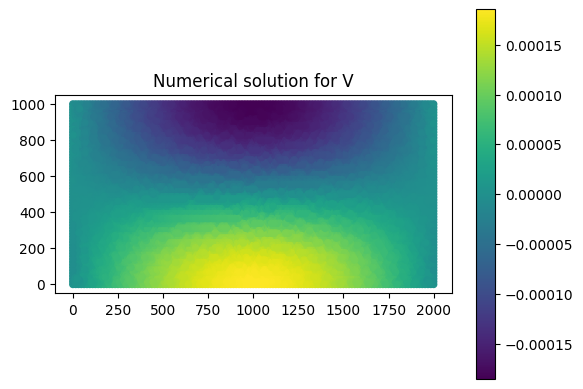

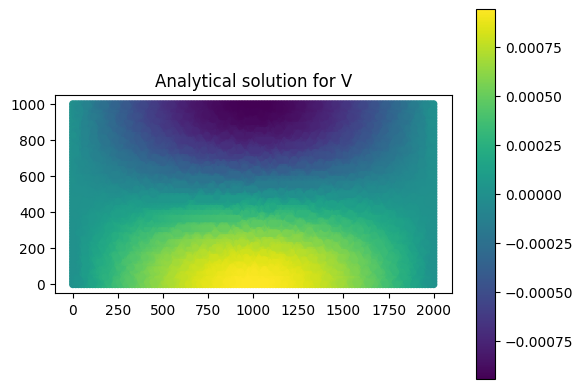

In [25]:
with meshbox.access(v_num):
    fig, ax = plt.subplots(dpi = 100)
    out = ax.scatter(v_num.coords[:, 0], v_num.coords[:, 1], c = v_num.data[:,0], s = 20)
    ax.set_aspect("equal")
    cbar = fig.colorbar(out)
    ax.set_title("Numerical solution for V")
 
    fig, ax = plt.subplots(dpi = 100)
    out2 = ax.scatter(v_soln.coords[:, 0], v_soln.coords[:, 1], c = v_soln.data[:, 1], s = 20)
    ax.set_aspect("equal")
    cbar2 = fig.colorbar(out2)
    ax.set_title("Analytical solution for V")

In [26]:
with meshbox.access(vel_num, u_num, v_num):

    vel_num.data [:,0] = u_num.data [:,0]
    vel_num.data [:,1] = v_num.data [:,0]

In [27]:
#l2 norm calculation
import math
def calculate_vec_h_norm():
    #sympy functions corresponding to integrals
    vec_diff = v_soln.sym - vel_num.sym
    vec_diff_mag = vec_diff.dot(vec_diff)

    vec_ana_mag = v_soln.sym.dot(v_soln.sym)

    vec_diff_mag_integ = math.sqrt(uw.maths.Integral(meshbox, vec_diff_mag).evaluate())
    vec_ana_mag_integ = math.sqrt(uw.maths.Integral(meshbox, vec_ana_mag).evaluate())
    vec_norm = vec_diff_mag_integ / vec_ana_mag_integ

    h_diff = (h_soln.sym - h_num.sym)**2
    h_ana_sq = h_soln.sym**2
    h_diff_integ = math.sqrt(uw.maths.Integral(meshbox, h_diff).evaluate())
    h_ana_sq_integ = math.sqrt(uw.maths.Integral(meshbox, h_ana_sq).evaluate())
    h_norm = h_diff_integ/h_ana_sq_integ
    return vec_norm, h_norm

In [28]:
calculate_vec_h_norm()

(0.8031540605697196, 0.8030049936505274)

In [29]:
meshbox.get_min_radius()

13.25678061259621

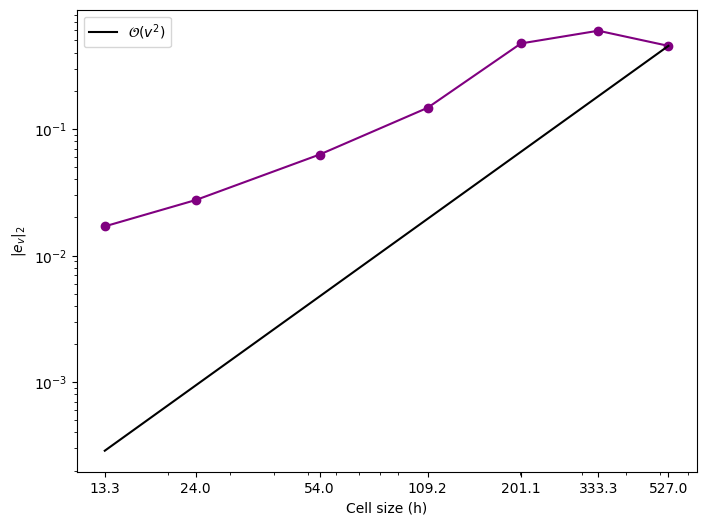

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Data
cell_size = [527.0462766947298, 333.3333333331935, 201.11999755874245, 
             109.22818795864026, 53.95733534287479, 24.02847481531693, 
             13.25678061259621]
v_norm = [0.4532600628897608, 0.5971237473004634, 0.47376604540273637, 
     0.14683885149113282, 0.06275316460527769, 0.02743882202772734, 
     0.016990447753729803]

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Set log scale for both axes
ax.set_xscale('log')
ax.set_yscale('log')

# Plot data with markers and line
ax.plot(cell_size, v_norm, marker='o', linestyle='-', color='purple')

# Set labels and title
ax.set_xlabel('Cell size (h)')
ax.set_ylabel(r'$|e_v|_2$')

# Define custom x-axis tick locations to match cell_size values
ax.set_xticks(cell_size)
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter()) 

# Adding the theoretical convergence rate line for reference

v_theoretical = np.linspace(min(cell_size), max(cell_size), 100)
convergence_rate = v_theoretical**2 * v_norm[0] / cell_size[0]**2  # Scale to fit initial point

ax.plot(v_theoretical, convergence_rate, 'k-', label=r'$\mathcal{O}(v^2)$')

# Add legend
ax.legend()

# Show the plot
plt.show()

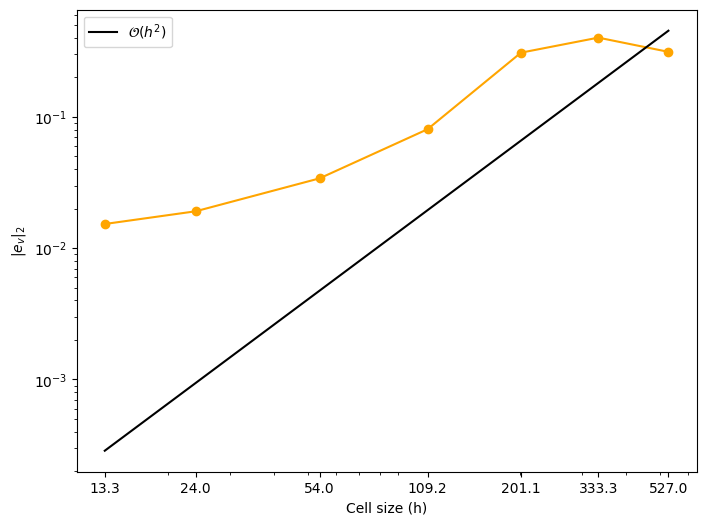

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Data
cell_size = [527.0462766947298, 333.3333333331935, 201.11999755874245, 
             109.22818795864026, 53.95733534287479, 24.02847481531693, 
             13.25678061259621]
h_norm = [0.31294633206013084,0.40154740367910724,0.3083924318298834,0.08054544594236261,0.03403755831227602,0.019111728491912883,0.01528481787910924]

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Set log scale for both axes
ax.set_xscale('log')
ax.set_yscale('log')

# Plot data with markers and line
ax.plot(cell_size, h_norm, marker='o', linestyle='-', color='orange')

# Set labels and title
ax.set_xlabel('Cell size (h)')
ax.set_ylabel(r'$|e_v|_2$')

# Define custom x-axis tick locations to match cell_size values
ax.set_xticks(cell_size)
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())  

# Adding the theoretical convergence rate line for reference

v_theoretical = np.linspace(min(cell_size), max(cell_size), 100)
convergence_rate = v_theoretical**2 * v_norm[0] / cell_size[0]**2  

ax.plot(v_theoretical, convergence_rate, 'k-', label=r'$\mathcal{O}(h^2)$')

# Add legend
ax.legend()

# Show the plot
plt.show()